# Week 11 — DBSCAN and Agglomerative Clustering (CKD Dataset)

Raw shape: (202, 29)
Numeric features: ['bp (diastolic)', 'bp limit', 'sg', 'al', 'rbc', 'su', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc', 'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'grf', 'stage', 'affected', 'age']
X shape: (202, 28)
Any NaNs left? 0
Scaled shape: (202, 28)

DBSCAN results:
  eps=0.50 | clusters=5 | noise=0.55 | silhouette=1.000
  eps=0.80 | clusters=5 | noise=0.55 | silhouette=1.000
  eps=1.00 | clusters=5 | noise=0.55 | silhouette=1.000
  eps=1.20 | clusters=5 | noise=0.55 | silhouette=1.000
  eps=1.50 | clusters=6 | noise=0.50 | silhouette=0.935
  eps=2.00 | clusters=6 | noise=0.50 | silhouette=0.935

Best DBSCAN eps by silhouette: eps=0.50, clusters=5, noise=0.55, silhouette=1.000

DBSCAN cluster counts (including noise = -1):
db_cluster
-1    112
 0      6
 1      8
 2     33
 3      5
 4     38
Name: count, dtype: int64

DBSCAN clusters vs CKD status (row-normalized, noise excluded):
             not_ckd       ckd
db_cluste

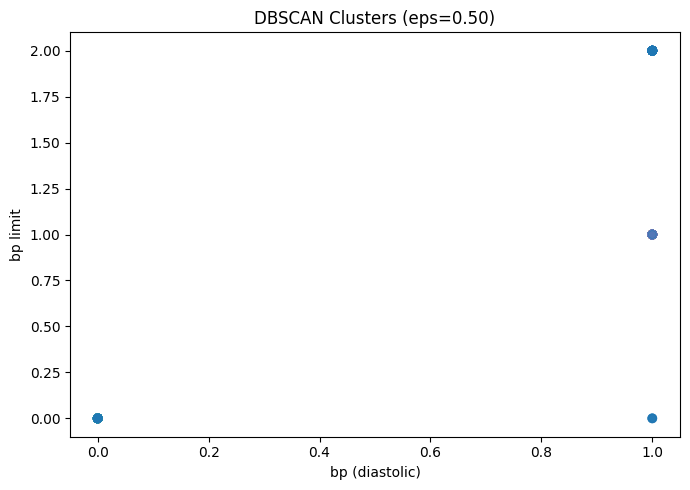


Agglomerative Clustering results:
  k=2: silhouette=0.218
  k=3: silhouette=0.241
  k=4: silhouette=0.254
  k=5: silhouette=0.264
  k=6: silhouette=0.280

Best Agglomerative k: 6 with silhouette=0.280

Agglomerative cluster counts:
agg_cluster
0    63
1    72
2    16
3    11
4    27
5    13
Name: count, dtype: int64

Agglomerative clusters vs CKD status (row-normalized):
              not_ckd       ckd
agg_cluster                    
0            0.031746  0.968254
1            1.000000  0.000000
2            0.000000  1.000000
3            0.000000  1.000000
4            0.000000  1.000000
5            0.000000  1.000000


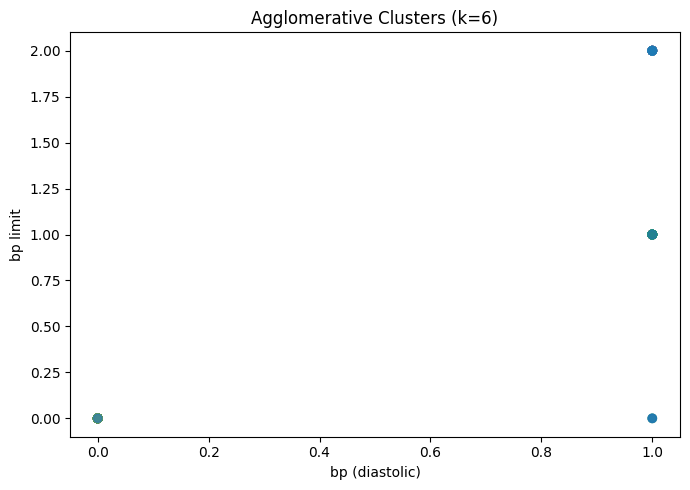

In [1]:
# ==== Week 11 – DBSCAN + Agglomerative Clustering (CKD Dataset) ====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

plt.rcParams["figure.figsize"] = (7, 5)

# 1. LOAD DATA
csv_path = "ckd_dataset_v2.csv"
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip().str.lower()
print("Raw shape:", df.shape)

# 2. TARGET + FEATURE PREP (same logic as Weeks 8–10)
if "class" not in df.columns:
    raise ValueError("Could not find 'class' column.")

df["class"] = df["class"].astype(str).str.strip().str.lower()
df["target"] = df["class"].map({"ckd": 1, "notckd": 0}).fillna(0).astype(int)

feature_cols = [c for c in df.columns if c not in ["class", "target"]]

# Convert non-target columns to numeric where possible
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "target"]

X = df[numeric_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)

# Handle columns that are all NaN
for col in X.columns:
    if X[col].isna().all():
        X[col] = 0

# Median imputation + final safety
X = X.fillna(X.median(numeric_only=True))
X = X.fillna(0)

print("Numeric features:", numeric_cols)
print("X shape:", X.shape)
print("Any NaNs left?", X.isna().sum().sum())

# 3. SCALE FEATURES
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled shape:", X_scaled.shape)

# --------------------------------------------------
# 4. DBSCAN: eps sweep + silhouette
# --------------------------------------------------

eps_values = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
min_samples = 5

db_results = []

print("\nDBSCAN results:")
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    # Number of clusters (excluding noise, labeled -1)
    unique, counts = np.unique(labels, return_counts=True)
    n_clusters = len([u for u in unique if u != -1])
    noise_frac = counts[unique == -1].sum() / len(labels) if -1 in unique else 0.0

    if n_clusters <= 1:
        sil = np.nan  # silhouette isn't meaningful
    else:
        sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])

    db_results.append((eps, n_clusters, noise_frac, sil))
    print(f"  eps={eps:.2f} | clusters={n_clusters} | noise={noise_frac:.2f} | silhouette={sil:.3f}")

# Choose best eps by silhouette (among valid silhouettes)
valid = [(eps, n_cl, nf, sil) for eps, n_cl, nf, sil in db_results if not np.isnan(sil) and n_cl > 1]
if valid:
    best_eps, best_n_cl, best_noise, best_sil = max(valid, key=lambda t: t[3])
    print(f"\nBest DBSCAN eps by silhouette: eps={best_eps:.2f}, "
          f"clusters={best_n_cl}, noise={best_noise:.2f}, silhouette={best_sil:.3f}")
else:
    best_eps = eps_values[0]
    print("\nNo valid silhouette scores for DBSCAN; using first eps as default:", best_eps)

# Fit final DBSCAN
db_final = DBSCAN(eps=best_eps, min_samples=min_samples)
db_labels = db_final.fit_predict(X_scaled)
df["db_cluster"] = db_labels

print("\nDBSCAN cluster counts (including noise = -1):")
print(df["db_cluster"].value_counts().sort_index())

# Crosstab vs CKD (excluding noise)
mask_non_noise = df["db_cluster"] != -1
if mask_non_noise.any():
    db_ctab = pd.crosstab(df.loc[mask_non_noise, "db_cluster"],
                          df.loc[mask_non_noise, "target"],
                          normalize="index")
    db_ctab.columns = ["not_ckd", "ckd"]
    print("\nDBSCAN clusters vs CKD status (row-normalized, noise excluded):")
    print(db_ctab)
else:
    print("\nAll DBSCAN points labeled as noise; no cluster vs CKD crosstab available.")

# Simple 2D visualization for DBSCAN
feat_x = numeric_cols[0]
feat_y = numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]

plt.figure()
scatter = plt.scatter(df[feat_x], df[feat_y],
                      c=df["db_cluster"], cmap="tab10", alpha=0.7)
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.title(f"DBSCAN Clusters (eps={best_eps:.2f})")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. Agglomerative Clustering: k sweep + silhouette
# --------------------------------------------------

agg_k_values = [2, 3, 4, 5, 6]
agg_scores = []

print("\nAgglomerative Clustering results:")
for k in agg_k_values:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    agg_scores.append(sil)
    print(f"  k={k}: silhouette={sil:.3f}")

best_k_agg = agg_k_values[int(np.argmax(agg_scores))]
best_sil_agg = max(agg_scores)
print(f"\nBest Agglomerative k: {best_k_agg} with silhouette={best_sil_agg:.3f}")

agg_final = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward")
agg_labels = agg_final.fit_predict(X_scaled)
df["agg_cluster"] = agg_labels

print("\nAgglomerative cluster counts:")
print(df["agg_cluster"].value_counts().sort_index())

agg_ctab = pd.crosstab(df["agg_cluster"], df["target"], normalize="index")
agg_ctab.columns = ["not_ckd", "ckd"]
print("\nAgglomerative clusters vs CKD status (row-normalized):")
print(agg_ctab)

# Simple 2D visualization for Agglomerative
plt.figure()
plt.scatter(df[feat_x], df[feat_y],
            c=df["agg_cluster"], cmap="tab10", alpha=0.7)
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.title(f"Agglomerative Clusters (k={best_k_agg})")
plt.tight_layout()
plt.show()
